In [1]:
import kabuki
import os
import hddm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import Parallel,delayed
from glob import glob
from kabuki.analyze import gelman_rubin
import arviz
import numpy as np
from patsy import dmatrix 

import ptitprince as pt

# rmANOVA
from statsmodels.stats.anova import AnovaRM


from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [7]:
# set the figure theme
sns.set_theme(style="whitegrid")

In [25]:
# load data
data = hddm.load_csv('./data.csv')

# stimulus onset time is 200, we should add it.
data['rt']=data['rt']+0.2
data.loc[(data['response']==1)&(data['stimulus']=='face'),'_response'] = 'face' #face
data.loc[(data['response']==1)&(data['stimulus']=='car'),'_response'] = 'car' #car
data.loc[(data['response']==0)&(data['stimulus']=='face'),'_response'] = 'car'
data.loc[(data['response']==0)&(data['stimulus']=='car'),'_response'] = 'face'
# rt of correct time should be positive, and rt of incorrect time should be negative.


In [26]:
# link function for stimulus, one stimulus should be coded 0, another should be coded 1
def z_link_func(x, data=data):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                                  {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
        )
        # Apply z = (1 - x) to flip them along 0.5
        z_flip = np.subtract(stim, x.to_frame())
        # The above inverts those values we do not want to flip,
        # so invert them back
        z_flip[stim == 0] *= -1
        return z_flip


In [27]:
def v_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ioc[x.index]})))
    return x * stim

In [28]:
data = data.drop("attention", axis=1)

In [29]:
data = data.rename(columns = {'coherency':'coherence',
                              'prioritization':'attention'})

In [30]:
data.rt.describe()

count    3661.000000
mean        0.637566
std         0.216022
min         0.200117
25%         0.506606
50%         0.588785
75%         0.704805
max         2.104793
Name: rt, dtype: float64

In [35]:
data = data.replace({'car':0,
                    'face':1,
                    'high':1,
                    'low':0,
                    'yes':1,
                    'no':0})

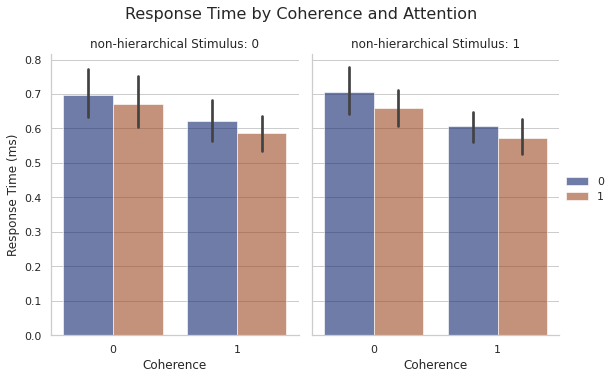

In [36]:
# get the mean of accurate RTs
data_rt_sum = data[data['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("non-hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

Text(0.5, 1, 'Response Time by Coherence and Attention')

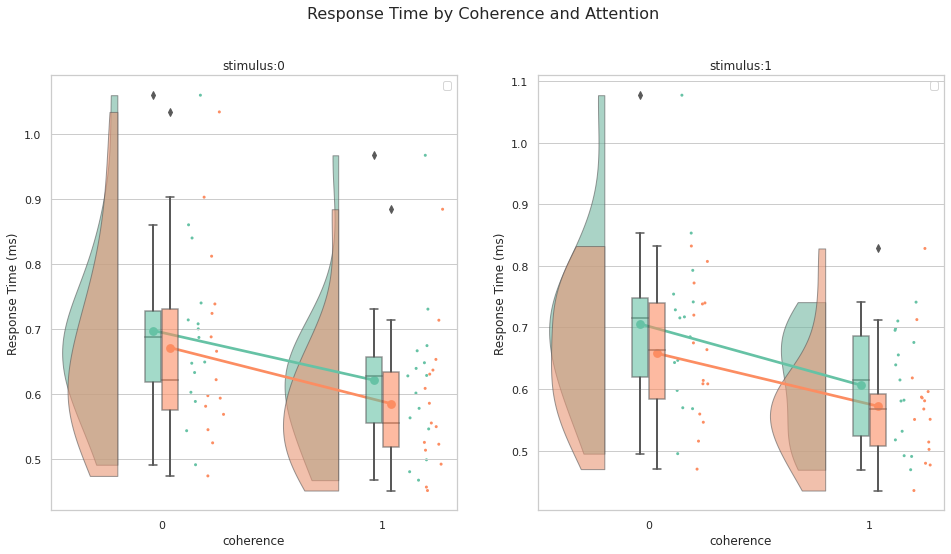

In [41]:
# create figure
f, ax = plt.subplots(1,2,figsize=(16, 8))

# non-hierarchical
ax[0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0].legend('')
ax[0].set_title('stimulus:0')
ax[0].set_ylabel('Response Time (ms)')
# the right figure
ax[1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1].legend('')
ax[1].set_title('stimulus:1')
ax[1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

In [42]:
# ANOVA for non-hierarchical
model_aovrm3way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                          Anova
                             F Value Num DF  Den DF Pr > F
----------------------------------------------------------
coherence                    31.2938 1.0000 14.0000 0.0001
attention                    14.7310 1.0000 14.0000 0.0018
stimulus                      0.3557 1.0000 14.0000 0.5604
coherence:attention           0.4077 1.0000 14.0000 0.5334
coherence:stimulus            1.4786 1.0000 14.0000 0.2441
attention:stimulus            0.6021 1.0000 14.0000 0.4507
coherence:attention:stimulus  2.2998 1.0000 14.0000 0.1516

                          Anova
                             F Value Num DF  Den DF Pr > F
----------------------------------------------------------
coherence                    41.0433 1.0000 14.0000 0.0000
attention                     5.9287 1.0000 14.0000 0.0289
stimulus                      3.2638 1.0000 14.0000 0.0924
coherence:attention           0.4158 1.0000 14.0000 0.5295
coherence:stimulus            1.6266 1.0000 14.000

<AxesSubplot:xlabel='response', ylabel='rt'>

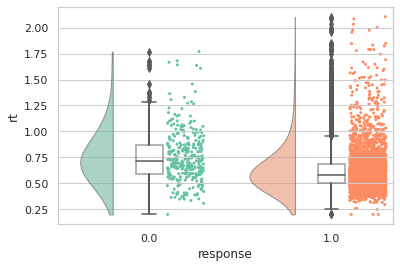

In [44]:
pt.RainCloud(x = 'response', 
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  )


<AxesSubplot:xlabel='stimulus', ylabel='rt'>

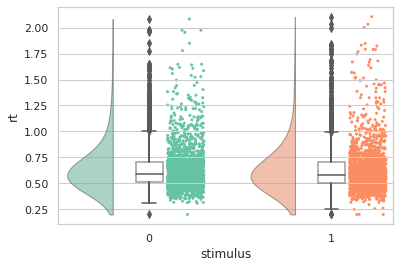

In [47]:
pt.RainCloud(x = 'stimulus', 
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  )

<AxesSubplot:xlabel='coherence', ylabel='rt'>

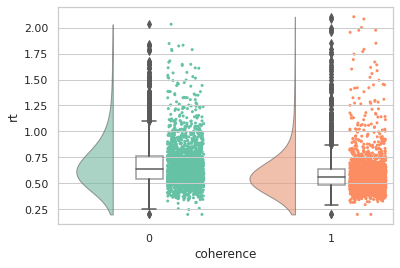

In [48]:
pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  )

<AxesSubplot:xlabel='attention', ylabel='rt'>

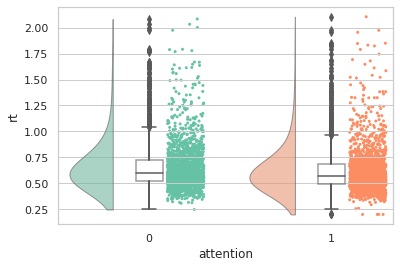

In [49]:
pt.RainCloud(x = 'attention', 
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  )

<AxesSubplot:xlabel='coherence', ylabel='cpp_slope'>

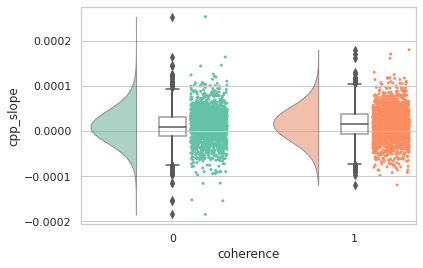

In [50]:
pt.RainCloud(x = 'coherence', 
                  y = 'cpp_slope', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  )

<AxesSubplot:xlabel='coherence', ylabel='cpp_amplitude'>

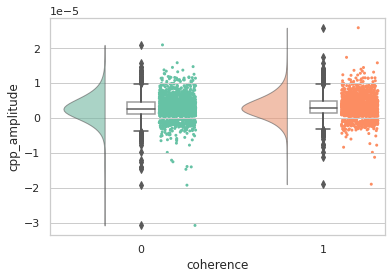

In [51]:
pt.RainCloud(x = 'coherence', 
                  y = 'cpp_amplitude', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  )

<AxesSubplot:xlabel='coherence', ylabel='cpp_peak'>

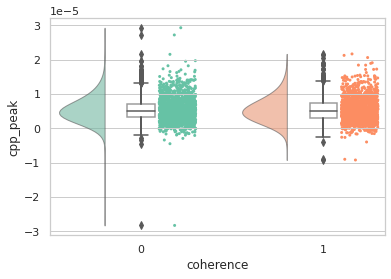

In [52]:
pt.RainCloud(x = 'coherence', 
                  y = 'cpp_peak', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  )

Text(0, 0.5, 'counts')

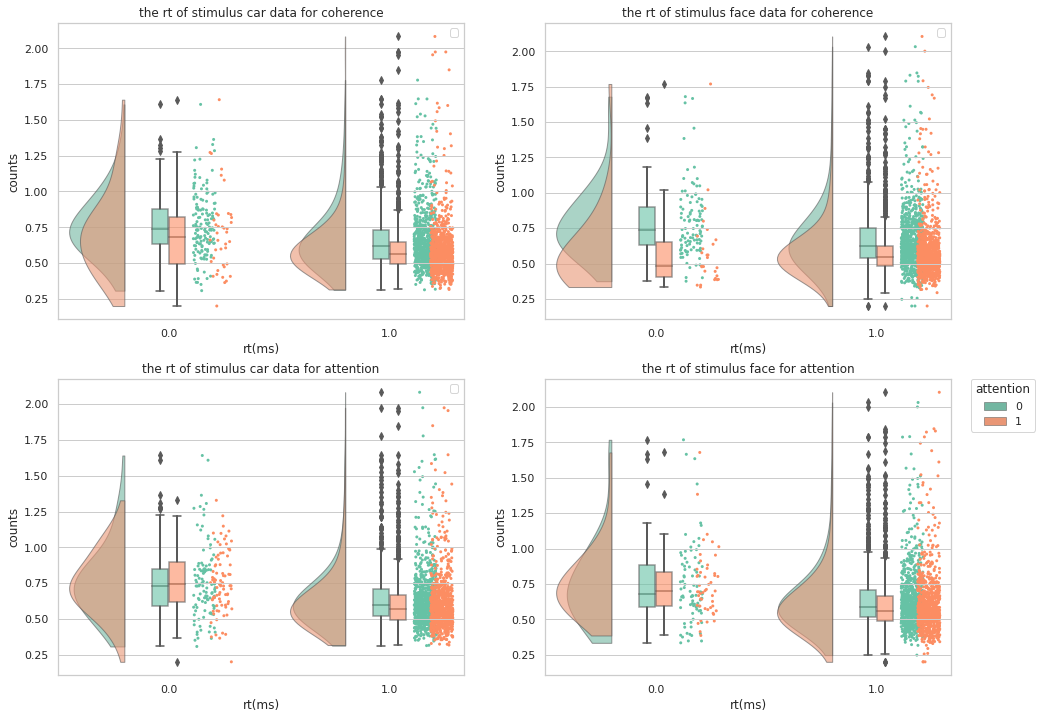

In [46]:
# create the figure 
f, ax = plt.subplots(2,2,figsize=(16, 12))

# the rt of hierarchical data for coherence
ax[0,0]=pt.RainCloud(x = 'response', 
                  hue='coherence',
                  y = 'rt', 
                  data = data[data['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('the rt of stimulus car data for coherence')
ax[0,0].set_xlabel('rt(ms)')
ax[0,0].set_ylabel('counts')
ax[0,0].legend('')

# the rt of non-hierarchical data for coherence
ax[0,1]=pt.RainCloud(x = 'response', 
                  hue='coherence',
                  y = 'rt', 
                  data = data[data['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('the rt of stimulus face data for coherence')
ax[0,1].set_xlabel('rt(ms)')
ax[0,1].set_ylabel('counts')
ax[0,1].legend('')

# the rt of hierarchical data for attention
ax[1,0]=pt.RainCloud(x = 'response', 
                  hue='attention',
                  y = 'rt', 
                  data = data[data['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('the rt of stimulus car data for attention')
ax[1,0].set_xlabel('rt(ms)')
ax[1,0].set_ylabel('counts')
ax[1,0].legend('')

# the rt of non-hierarchical data for attention
ax[1,1]=pt.RainCloud(x = 'response', 
                  hue='attention',
                  y = 'rt', 
                  data = data[data['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,1],
                    )
# the labels of hierarchical data
ax[1,1].set_title('the rt of stimulus face for attention')
ax[1,1].set_xlabel('rt(ms)')
ax[1,1].set_ylabel('counts')